In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from copy import deepcopy
import random
import os
import PIL
import cv2 as cv
import numpy as np

FINAL MODEL PIPELINE

In [2]:
def load_images_path(path):
    images_path = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".png"):
                images_path.append(os.path.join(root, file))
    return images_path

from torchvision import transforms
import torch
from PIL import Image

def load_transform_image(image_path):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((128, 128)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image = Image.open(image_path).convert('L') 
    return transform(image)

def load_images_dataset():
    categories = ["40_Percent", "70_Percent", "80_Percent", "100_Percent"]
    labels = {"40_Percent": 0, "70_Percent": 1, "80_Percent": 2, "100_Percent": 3}
    dataset = []
    for category in categories:
        path = f"data/{category}"
        for image_path in load_images_path(path):
            image_tensor = load_transform_image(image_path)
            dataset.append((image_tensor, labels[category]))
    return dataset

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:


class CustomDataset(Dataset):
    def __init__(self):
        self.data = load_images_dataset()
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        image = self.transform(image)
        return image, label

class CNN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.MaxPool2d(2, 2))
        dummy_input =torch.zeros(1,*input_shape)
        output_size = self.conv_layers(dummy_input).nelement()
        self.fc_input_size = output_size//dummy_input.size(0)
        self.fc_layers = nn.Sequential(nn.Linear(self.fc_input_size, 256),nn.ReLU(),nn.Dropout(0.5),nn.Linear(256, num_actions))
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


class AlgaePPO:
    def __init__(self, device, num_models, policy_class, input_shape, num_actions):
        self.device = device
        self.policies = [policy_class(input_shape, num_actions).to(device) for _ in range(num_models)]
        self.optimizers = [torch.optim.Adam(policy.parameters()) for policy in self.policies]
        self.scheduler = [lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) for optimizer in self.optimizers]
        self.loss_fn = nn.CrossEntropyLoss()

    def train(self, dataset,episodes):
        loader = DataLoader(dataset, batch_size=4, shuffle=True)
        accuracy_score =[]
        episode_list =[]
        for episode in range(episodes):
            for model_idx, policy in enumerate(self.policies):
                optimizer = self.optimizers[model_idx]
                total_loss = 0
                total = 0
                correct = 0
                for inputs,labels in loader:
                    inputs,labels = inputs.to(self.device), labels.to(self.device)
                    outputs=policy(inputs)
                    loss=self.loss_fn(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss+=loss.item()
                    _,predicted=torch.max(outputs, 1)
                    total+=labels.size(0)
                    correct+=(predicted==labels).sum().item()
                accuracy = 100 * correct / total
                accuracy_score.append(accuracy)
                episode_list.append(episode)
                print(f"Model {model_idx+1} Episode {episode+1} Loss: {total_loss} Accuracy: {accuracy}")

            if episode % 5 == 0: 
                self.evolve()
        return episode_list, accuracy_score

    def evolve(self):
        parent1, parent2 = np.random.choice(self.policies, 2, replace=False)
        child_weights = {}
        for (name1, param1), (name2, param2) in zip(parent1.named_parameters(), parent2.named_parameters()):
            if np.random.rand() > 0.5:
                child_weights[name1] = param1.data.clone()
            else:
                child_weights[name1] = param2.data.clone()
        for name in child_weights:
            if np.random.rand() < 0.1:
                mutation = torch.randn_like(child_weights[name]) * 0.1
                child_weights[name] += mutation
        worst_model_idx = np.random.randint(len(self.policies))
        for name, param in self.policies[worst_model_idx].named_parameters():
            param.data.copy_(child_weights[name])
        print("Population evolved")

    def evaluate(self, test_loader):
        model_accuracies = []
        with torch.no_grad():
            for idx, model in enumerate(self.policies):
                correct = 0
                total = 0
                for inputs,labels in test_loader:
                    inputs, labels = inputs.to(self.device),labels.to(self.device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    correct += (predicted==labels).sum().item()
                    total += labels.size(0)
                accuracy = 100*correct/total
                model_accuracies.append(accuracy)
                print(f"Model {idx+1} Accuracy on Test Set: {accuracy:.2f}%")
        return model_accuracies
    
    def predict(self, data_loader):
        model = self.model 
        model.eval()
        predictions = []
        with torch.no_grad():
            for data in data_loader:
                processed_data=self._preprocess_data(data) 
                output=model(processed_data.to(self.device))
                predicted=torch.max(output, 1)[1] 
                predictions.extend(predicted.tolist())
        return predictions

    def _preprocess_data(self,batch):
        images, _ =batch
        return images  
    def _preprocess_data(self,data):
        transform = transforms.Compose([transforms.Resize((128,128)),transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])
        return transform(data).unsqueeze(0) 
    def save_model(self,path="best_model.pth"):
        self.policies.sort(key=lambda x: self.evaluate(x),reverse=True)
        model=self.policies[0]
        torch.save(model.state_dict(),path)
        print("Model saved successfully")
    def load_model(self,path="best_model.pth"):
        model = CNN((1,128,128),4)
        model.load_state_dict(torch.load(path))
        print("Model loaded successfully")



In [4]:
device=torch.device("cuda")
trainer=AlgaePPO(device=device,num_models=3,policy_class=CNN,input_shape=(1,128,128),num_actions=4)
train_dataset=CustomDataset()
episode_list,accuracy_scores=trainer.train(train_dataset,episodes=50)

C:\Users\virad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\modules\module.py:1150: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:30.)
  return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)


Model 1 Episode 1 Loss: 2619.0709988690255 Accuracy: 86.41141141141141
Model 2 Episode 1 Loss: 1474.3602901811964 Accuracy: 87.53753753753753
Model 3 Episode 1 Loss: 2027.4311151291577 Accuracy: 86.56156156156156
Population evolved
Model 1 Episode 2 Loss: 787.5723729738254 Accuracy: 93.69369369369369
Model 2 Episode 2 Loss: 387.03243208456286 Accuracy: 97.14714714714715
Model 3 Episode 2 Loss: 520.1712349157671 Accuracy: 95.42042042042043
Model 1 Episode 3 Loss: 72.66406237495335 Accuracy: 98.42342342342343
Model 2 Episode 3 Loss: 179.11187670463596 Accuracy: 98.57357357357357
Model 3 Episode 3 Loss: 44.95740764180343 Accuracy: 99.09909909909909
Model 1 Episode 4 Loss: 15.014921456789883 Accuracy: 99.17417417417417
Model 2 Episode 4 Loss: 63.94839737054099 Accuracy: 99.54954954954955
Model 3 Episode 4 Loss: 58.88699774074459 Accuracy: 99.17417417417417
Model 1 Episode 5 Loss: 137.48529369076795 Accuracy: 97.97297297297297
Model 2 Episode 5 Loss: 38.67308601684291 Accuracy: 99.474474474

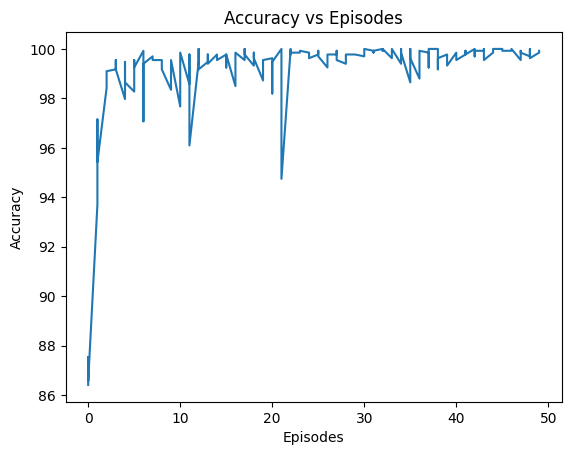

In [5]:
plt.plot(episode_list,accuracy_scores)
plt.xlabel("Episodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Episodes")
plt.show()

In [6]:
trainer.save_model("model_classification.pth")

Model saved successfully


In [7]:
dataset = CustomDataset()
data = DataLoader(dataset,batch_size=1,shuffle=True)
trainer.evaluate(data)

Model 1 Accuracy on Test Set: 100.00%
Model 2 Accuracy on Test Set: 99.92%
Model 3 Accuracy on Test Set: 99.77%


[100.0, 99.92492492492492, 99.77477477477477]